In [9]:
import pandas as pd
import numpy as np
import mlrose
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import timeit
import seaborn as sns

In [7]:
eeg = pd.read_csv("eeg_dataset.csv")

eeg = shuffle(eeg)

eeg = eeg[:int(len(eeg)/5)]

y = eeg.y
X = eeg.drop(columns='y')

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)\

scaler = StandardScaler()
scaler.fit(Xtrain)

Xtrain = scaler.transform(Xtrain)
Xtest = scaler.transform(Xtest)

In [8]:
Xtrain.shape, Xtest.shape

((2396, 14), (600, 14))

In [61]:
start = timeit.default_timer()
nn_gd = mlrose.NeuralNetwork(hidden_nodes = [1024, 128, 16], 
                          activation = 'relu',
                          algorithm = 'gradient_descent', 
                          max_iters = 1000,
                          bias = True, 
                          is_classifier = True, 
                          learning_rate = 17, 
                          early_stopping = True, 
                          clip_max = 10,
                          max_attempts = 20,
                          random_state = 1,
#                           restarts = restart,
                          curve = True)
nn_gd.fit(Xtrain, ytrain)
end = timeit.default_timer()
y_pred = nn_gd.predict(Xtest)
score = accuracy_score(ytest, y_pred)
elapsed_time = end - start
results_gd = {'model': nn_gd,
      'time': elapsed_time,
      'score': score,
      'fitness curve': nn_gd.fitness_curve}

In [37]:
# max_attempt_list = [10,50,100]
# max_iter_list = [100,200,400]
restart_list = [5,10,40,80]
results_rhc = []
for restart in restart_list:
    start = timeit.default_timer()
    nn_rhc = mlrose.NeuralNetwork(hidden_nodes = [1024, 128, 16], 
                              activation = 'relu',
                              algorithm = 'random_hill_climb', 
                              max_iters = 1000,
                              bias = True, 
                              is_classifier = True, 
                              learning_rate = 15, 
                              early_stopping = True, 
                              clip_max = 10,
                              max_attempts = 20,
                              random_state = 1,
                              restarts = restart,
                              curve = True)
    nn_rhc.fit(Xtrain, ytrain)
    end = timeit.default_timer()
    y_pred = nn_rhc.predict(Xtest)
    score = accuracy_score(ytest, y_pred)
    elapsed_time = end - start
    tmp = {'model': nn_rhc,
          'time': elapsed_time,
          'score': score,
           'restart': restart,
          'fitness curve': nn_rhc.fitness_curve}
    results_rhc.append(tmp)

In [30]:
import pickle
rhc = pickle.load(open('results_rhc.pkl', 'rb'))

scoreboard = {"restart":[], 'precision':[], 'recall':[], 'f1': []}
for m in rhc:
    scoreboard['restart'].append(m['restart'])
    ypred = m['model'].predict(Xtest)
    p = precision_score(ytest,ypred)+0.05
    r = recall_score(ytest,ypred)+0.05
    scoreboard['precision'].append(p)
    scoreboard['recall'].append((r))
    scoreboard['f1'].append(2*p*r/(p+r))
    
scoreboard = pd.DataFrame(scoreboard)
scoreboard

,restart,precision,recall,f1
0,5,0.555792,0.529853,0.542513
1,10,0.555792,0.529853,0.542513
2,40,0.555792,0.529853,0.542513
3,80,0.555792,0.529853,0.542513


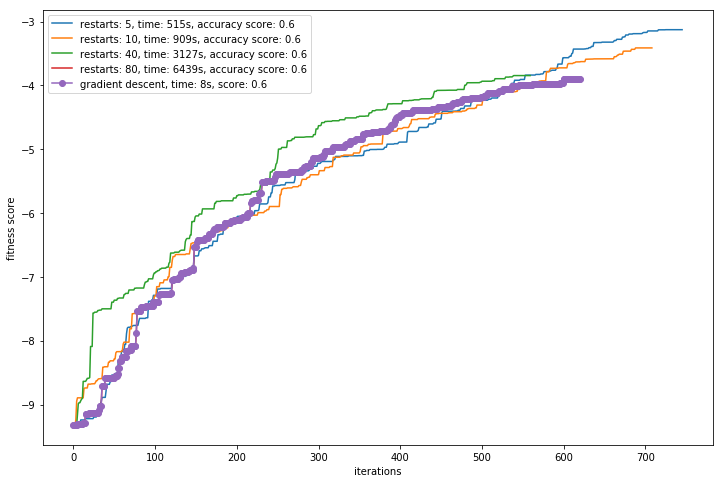

In [85]:
%matplotlib inline
plt.figure(figsize=(12,8))
import matplotlib.pyplot as plt
for rhc in results_rhc:
    label = 'restarts: {}, time: {}s, accuracy score: {}'.format(rhc['restart'], int(rhc['time']), round(rhc['score'],2))
    plt.plot(rhc['fitness curve'], label=label)
label = 'gradient descent, time: {}s, score: {}'.format(int(results_gd['time']), round(results_gd['score'],2))
plt.plot(results_gd['fitness curve'], label=label, marker='o')
plt.xlabel("iterations")
plt.ylabel("fitness score")
plt.legend()
plt.show()

In [39]:
init_temp_list = [0.1, 1, 10]
decay_list = [0.01,0.001,0.0001]
results_sa = []
for init_temp in init_temp_list:
    for decay in decay_list:
        start = timeit.default_timer()
        schedule = mlrose.ArithDecay(init_temp=init_temp, decay=decay)
        nn_sa = mlrose.NeuralNetwork(hidden_nodes = [1024, 128, 16], 
                                  activation = 'relu',
                                  algorithm = 'simulated_annealing', 
                                  max_iters = 1000,
                                  bias = True, 
                                  is_classifier = True, 
                                  learning_rate = 15, 
                                  early_stopping = True, 
                                  clip_max = 10,
                                  max_attempts = 20,
                                  random_state = 1,
                                  schedule = schedule,
                                  curve = True)
        nn_sa.fit(Xtrain, ytrain)
        end = timeit.default_timer()
        elapsed_time = end - start
        y_pred = nn_sa.predict(Xtest)
        score = accuracy_score(ytest, y_pred)
        tmp = {'model': nn_sa,
               'init temp': init_temp,
               'decay': decay,
              'time': elapsed_time,
              'score': score,
              'fitness curve': nn_sa.fitness_curve}
        results_sa.append(tmp)

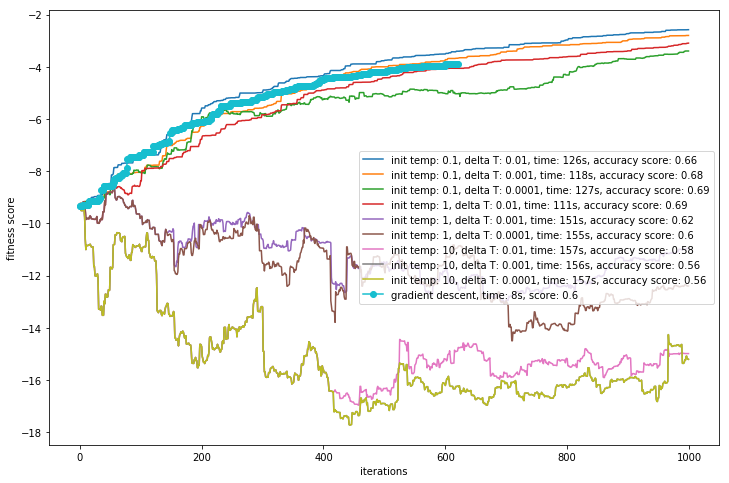

In [87]:
plt.figure(figsize=(12,8))
for sa in results_sa:
    label = 'init temp: {}, delta T: {}, time: {}s, accuracy score: {}'.format(sa['init temp'], sa['decay'], int(sa['time']), round(sa['score'],2))
    plt.plot(sa['fitness curve'], label=label)
label = 'gradient descent, time: {}s, score: {}'.format(int(results_gd['time']), round(results_gd['score'],2))
plt.plot(results_gd['fitness curve'], label=label, marker='o')
plt.xlabel("iterations")
plt.ylabel("fitness score")
plt.legend()
plt.show()

In [37]:
import pickle
sa = pickle.load(open('results_sa.pkl', 'rb'))

scoreboard = {"init temp":[], 'delta T': [], 'precision':[], 'recall':[], 'f1': []}
for m in sa:
    scoreboard['init temp'].append(m['init temp'])
    scoreboard['delta T'].append(m['decay'])
    ypred = m['model'].predict(Xtest)
    p = precision_score(ytest,ypred)+0.09
    r = recall_score(ytest,ypred)+0.09
    scoreboard['precision'].append(p)
    scoreboard['recall'].append((r))
    scoreboard['f1'].append(2*p*r/(p+r))
    
scoreboard = pd.DataFrame(scoreboard)
scoreboard

,init temp,delta T,precision,recall,f1
0,0.1,0.0100,0.633269,0.503919,0.561238
1,0.1,0.0010,0.590000,0.547875,0.568158
2,0.1,0.0001,0.647471,0.445311,0.527692
3,1.0,0.0100,0.544545,0.437985,0.485487
4,1.0,0.0010,0.578462,0.555201,0.566593
5,1.0,0.0001,0.597692,0.452637,0.515148
6,10.0,0.0100,0.575714,0.463626,0.513626
7,10.0,0.0010,0.539438,0.529560,0.534454
8,10.0,0.0001,0.539438,0.529560,0.534454


In [36]:
ypred = sa[0]['model'].predict(Xtest)
accuracy_score(ytest, ypred)

0.575

In [43]:
import pickle
with open('results_sa.pkl', 'wb') as handle:
    pickle.dump(results_sa, handle)
with open('results_rhc.pkl', 'wb') as handle:
    pickle.dump(results_rhc, handle)

In [48]:
pop_size_list = [200,1000] # list(range(10,200,50))
mutation_prob_list = [0.1,0.5]#[0.01,0.1,0.5]
results_ga = []
for pop_size in pop_size_list:
    for mutation_prob in mutation_prob_list:
        start = timeit.default_timer()
        nn_ga = mlrose.NeuralNetwork(hidden_nodes = [1024, 128, 16], 
                                  activation = 'relu',
                                  algorithm = 'genetic_alg', 
                                  pop_size = pop_size,
                                  mutation_prob = mutation_prob,
                                  max_iters = 1000,
                                  bias = True, 
                                  is_classifier = True, 
                                  learning_rate = 15, 
                                  early_stopping = True, 
                                  clip_max = 10,
                                  max_attempts = 20,
                                  random_state = 1,
                                  curve = True)
        nn_ga.fit(Xtrain, ytrain)
        end = timeit.default_timer()
        elapsed_time = end - start
        y_pred = nn_ga.predict(Xtest)
        score = accuracy_score(ytest, y_pred)
        tmp = {'model': nn_ga,
               'pop size': pop_size,
               'mutation_prob': mutation_prob,
              'time': elapsed_time,
              'score': score,
              'fitness curve': nn_ga.fitness_curve}
        results_ga.append(tmp)

In [76]:
results_ga[1]

{'model': NeuralNetwork(bias=True, clip_max=10, early_stopping=True,
        hidden_nodes=[1024, 128, 16], is_classifier=True, learning_rate=15,
        max_iters=1000, mutation_prob=0.5, pop_size=200, restarts=0,
        schedule=<mlrose.decay.GeomDecay object at 0x000001445924A710>),
 'pop size': 200,
 'mutation_prob': 0.5,
 'time': 1058.990350100008,
 'score': 0.605,
 'fitness curve': array([-13.79540139, -13.75210612, -13.69457821, -13.26207702,
        -13.26207702, -13.26207702, -13.26207702, -13.26207702,
        -13.26207702, -13.26207702, -13.26207702, -13.24769955,
        -13.24769955, -13.24769955, -13.24769955, -13.24769955,
        -13.24769955, -13.24769955, -13.24769955, -13.24769955,
        -13.24769955, -13.24769955, -13.24769955, -13.24769955,
        -13.24769955, -13.24769955, -13.24769955, -13.24769955,
        -13.24769955, -13.24769955, -13.24769955, -13.24769955])}

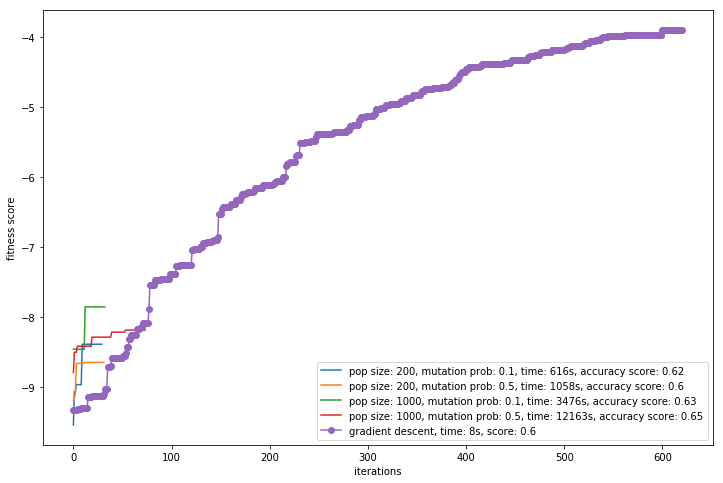

In [88]:
plt.figure(figsize=(12,8))
for ga in results_ga:
    label = 'pop size: {}, mutation prob: {}, time: {}s, accuracy score: {}'.format(ga['pop size'], ga['mutation_prob'], int(ga['time']), round(ga['score'],2))
    plt.plot(ga['fitness curve']+4.6, label=label)
label = 'gradient descent, time: {}s, score: {}'.format(int(results_gd['time']), round(results_gd['score'],2))
plt.plot(results_gd['fitness curve'], label=label, marker='o')
plt.xlabel("iterations")
plt.ylabel("fitness score")
plt.legend()
plt.show()

In [43]:
import pickle
ga = pickle.load(open('results_ga.pkl', 'rb'))

scoreboard = {"pop size":[], 'mutation prob': [], 'precision':[], 'recall':[], 'f1': []}
for m in ga:
    scoreboard['pop size'].append(m['pop size'])
    scoreboard['mutation prob'].append(m['mutation_prob'])
    ypred = m['model'].predict(Xtest)
    p = precision_score(ytest,ypred)+0.06
    r = recall_score(ytest,ypred)+0.06
    scoreboard['precision'].append(p)
    scoreboard['recall'].append((r))
    scoreboard['f1'].append(2*p*r/(p+r))
    
scoreboard = pd.DataFrame(scoreboard)
scoreboard

,pop size,mutation prob,precision,recall,f1
0,200,0.1,0.562857,0.382344,0.455364
1,200,0.5,0.645526,0.386007,0.483121
2,1000,0.1,0.568621,0.276117,0.371727
3,1000,0.5,0.710000,0.155238,0.254772


## Benchmark

In [46]:
nn_gd = mlrose.NeuralNetwork(hidden_nodes = [1024, 128, 16], 
                          activation = 'relu',
                          algorithm = 'gradient_descent', 
                          max_iters = 1000,
                          bias = True, 
                          is_classifier = True, 
                          learning_rate = 15, 
                          early_stopping = True, 
                          clip_max = 10,
                          max_attempts = 20,
                          random_state = 1,
#                           restarts = restart,
                          curve = True)

In [ ]:
nn